In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

### Solving Machine Learning Problems
Solving a machine leanring problem usually consists of the following steps:
- Obtain training data
- Define the model
- Define a loss function
- Run through the training data, calculating loss from the ideal value
- Calculate gradients for that loss and use an optimizer to adjust the variables to fit the data
- Evaluate your results

For illustration purposes, lets develop a small model [f(x) = x*W+b], which has two varaibles: W (weights) and b (bias). This is the most basic of machine learning problems: Given x and y, try to find the slope and offset of a line via simple linear regression

#### Data
- Supervised learning uses inputs(usually denoted as x) and outputs(denoted y, often called labels). 
- The goal is to learn from paired input and outputs os that we can predict the value of an output from an input.
- Each input of our data, in Tensorflow, is almost always represented by a tenosr, and is often a vector.
- In supervised traininng, the output (or value you'd like to predict) is also a tensor
- Here is some data systheised by adding Gaussain (Normal) noise to points along a line

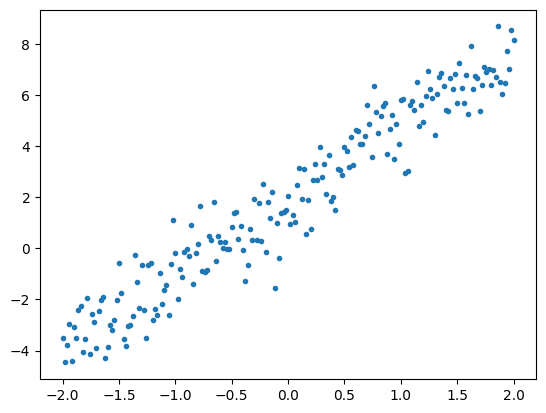

In [7]:
# The Actual line parameters
TRUE_W = 3.0
TRUE_B = 2.0

NUM_EXAMPLES = 201

# A vector of random x values
x = tf.linspace(-2, 2, NUM_EXAMPLES)
x = tf.cast(x,tf.float32)

def f(x):
    return x*TRUE_W+TRUE_B

# Generate Some Noise
noise = tf.random.normal(shape=[NUM_EXAMPLES])
# Calclualte y
y = f(x)+noise


# Plot all the Data
plt.plot(x,y,'.')
plt.show()

- Tensors are usually gathered together in batches, or groups of inputs and outputs stacked together. 
- Batching can confer some training benefits and works well with accelerators and vectorized computation. 
- Given how small this dataset is, you can treat the entire dataset as a single batch.

### Define the Model
- Use tf.Variable to represent all weights in a model. A tf.Variable stores a value and provides this in tensor form as needed.
- Use tf.Module to encapsulate the variables and the computation. You could use any Python object, but this way it can be easily saved.
- Here, you define both w and b as variables.

In [10]:
class MyModel(tf.Module):
    def __init__(self, **kwargs):
        super(MyModel, self).__init__(**kwargs)
        # Initialize the weights to `5.0` and the bias to `0.0`
        # In practice, these should be randomly initialized
        self.w = tf.Variable(5.0)
        self.b = tf.Variable(0.0)
    def __call__(self, x):
        return x*self.w + self.b
    
model = MyModel()

# Print list of variables tf.modules built in variable aggregation
print("Vraiables: ",model.variables)

# Verify the model works
assert model(3.0).numpy() == 15.0

# The initial variables are set here in a fixed way, but Keras comes with any of a number of initializers you could use, with or without the rest of Keras.

Vraiables:  (<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=5.0>)


### Define a Loss Function
A loss function measures how well the output of a model for a given input matches the target output. The goal is to minimize this difference during training. Define the standard L2 loss, also known as the "mean squared" error:

In [11]:
def loss(target_y, predicted_y):
    return tf.reduce_mean(tf.square(target_y-predicted_y))


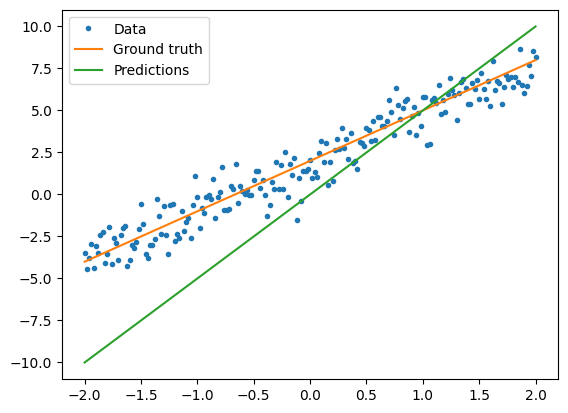

Current loss: 10.334938


In [12]:
# Before training the model, you can visualize the loss value by plotting the model's 
# predictions in red and the training data in blue:
plt.plot(x, y, '.', label="Data")
plt.plot(x, f(x), label="Ground truth")
plt.plot(x, model(x), label="Predictions")
plt.legend()
plt.show()

print("Current loss: %1.6f" % loss(y, model(x)).numpy())

### Define a Training Loop
The training loop consists of repeatedly doing three tasks in order:
- Sending a batch of inputs through the model to generate outputs
- Calculating the loss by comparing the outputs to the output (or label)
- Using gradient tape to find the gradients
- Optimizing the variables with those gradients
For this example, you can train the model using gradient descent.

In [13]:
# Given a callable model, inputs, outputs, and a learning rate...
def train(model, x, y, learning_rate):
    with tf.GradientTape() as tape:
        # Trainable variables are automatically tracked by GradientTape
        current_loss = loss(y, model(x))
    
    # Use GradientTape to calculate the gradients with respect to W and b
    dw, db = tape.gradient(current_loss, [model.w, model.b])
    # Subtract the gradient scaled by the learning rate
    model.w.assign_sub(learning_rate*dw)
    model.b.assign_sub(learning_rate*db)

In [14]:
# For a look at training, you can send the same batch of x and y through the training loop, and see how W and b evolve.
model = MyModel()
# Collect the history of W-values and b-values to plot later
weights = []
biases = []
epochs = range(10)

# Define a training loop
def report(model, loss):
    return f"W = {model.w.numpy():1.2f}, b = {model.b.numpy():1.2f}, loss={loss:2.5f}"

def training_loop(model, x, y):
    for epoch in epochs:
        # Update the model with the single giant batch
        train(model, x, y, learning_rate=0.1)
        # Track this before I update
        weights.append(model.w.numpy())
        biases.append(model.b.numpy())
        current_loss = loss(y, model(x))

        print(f"Epoch {epoch:2d}:")
        print("    ", report(model, current_loss))

current_loss = loss(y, model(x))

print(f"Starting:")
print("    ", report(model, current_loss))

training_loop(model, x, y)


Starting:
     W = 5.00, b = 0.00, loss=10.33494
Epoch  0:
     W = 4.44, b = 0.38, loss=6.29484
Epoch  1:
     W = 4.03, b = 0.68, loss=4.00056
Epoch  2:
     W = 3.72, b = 0.93, loss=2.68778
Epoch  3:
     W = 3.50, b = 1.12, loss=1.93065
Epoch  4:
     W = 3.34, b = 1.27, loss=1.49042
Epoch  5:
     W = 3.23, b = 1.40, loss=1.23234
Epoch  6:
     W = 3.14, b = 1.50, loss=1.07981
Epoch  7:
     W = 3.08, b = 1.58, loss=0.98894
Epoch  8:
     W = 3.03, b = 1.64, loss=0.93438
Epoch  9:
     W = 3.00, b = 1.69, loss=0.90139


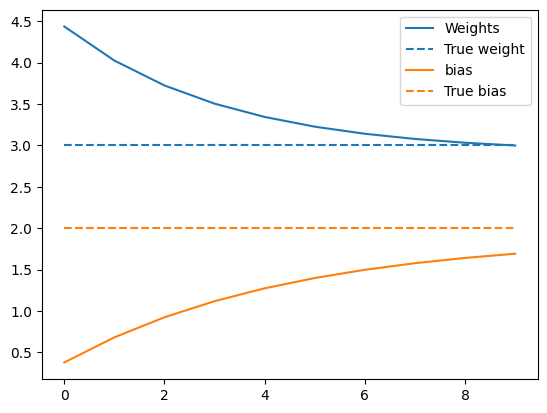

In [15]:
# Plot the evolution of the weights over time:
plt.plot(epochs, weights, label='Weights', color=colors[0])
plt.plot(epochs, [TRUE_W] * len(epochs), '--',
         label = "True weight", color=colors[0])

plt.plot(epochs, biases, label='bias', color=colors[1])
plt.plot(epochs, [TRUE_B] * len(epochs), "--",
         label="True bias", color=colors[1])

plt.legend()
plt.show()

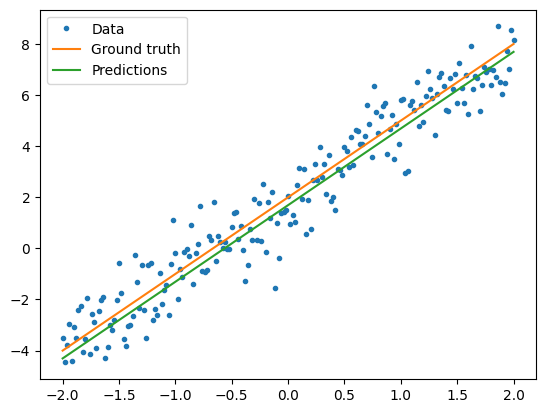

Current loss: 0.901389


In [16]:
# Visualize how the trained model performs
plt.plot(x, y, '.', label="Data")
plt.plot(x, f(x), label="Ground truth")
plt.plot(x, model(x), label="Predictions")
plt.legend()
plt.show()

print("Current loss: %1.6f" % loss(model(x), y).numpy())

### The Same Solution with KERAS
It's useful to contrast the code above with the equivalent in Keras.

Defining the model looks exactly the same if you subclass tf.keras.Model. Remember that Keras models inherit ultimately from module.

In [17]:
class MyModelKeras(tf.keras.Model):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    # Initialize the weights to `5.0` and the bias to `0.0`
    # In practice, these should be randomly initialized
    self.w = tf.Variable(5.0)
    self.b = tf.Variable(0.0)

  def call(self, x):
    return self.w * x + self.b

keras_model = MyModelKeras()

# Reuse the training loop with a Keras model
training_loop(keras_model, x, y)

# You can also save a checkpoint using Keras's built-in support
keras_model.save_weights("my_checkpoint")

Epoch  0:
     W = 4.44, b = 0.38, loss=6.29484
Epoch  1:
     W = 4.03, b = 0.68, loss=4.00056
Epoch  2:
     W = 3.72, b = 0.93, loss=2.68778
Epoch  3:
     W = 3.50, b = 1.12, loss=1.93065
Epoch  4:
     W = 3.34, b = 1.27, loss=1.49042
Epoch  5:
     W = 3.23, b = 1.40, loss=1.23234
Epoch  6:
     W = 3.14, b = 1.50, loss=1.07981
Epoch  7:
     W = 3.08, b = 1.58, loss=0.98894
Epoch  8:
     W = 3.03, b = 1.64, loss=0.93438
Epoch  9:
     W = 3.00, b = 1.69, loss=0.90139


- Rather than write new training loops each time you create a model, you can use the built-in features of Keras as a shortcut. - This can be useful when you do not want to write or debug Python training loops.
- If you do, you will need to use model.compile() to set the parameters, and model.fit() to train. 
- It can be less code to use Keras implementations of L2 loss and gradient descent, again as a shortcut. 
- Keras losses and optimizers can be used outside of these convenience functions, too, and the previous example could have used them.

In [18]:
keras_model = MyModelKeras()

# compile sets the training parameters
keras_model.compile(
    # By default, fit() uses tf.function().  You can
    # turn that off for debugging, but it is on now.
    run_eagerly=False,

    # Using a built-in optimizer, configuring as an object
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),

    # Keras comes with built-in MSE error
    # However, you could use the loss function
    # defined above
    loss=tf.keras.losses.mean_squared_error,
)

In [19]:
# Keras fit expects batched data or a complete dataset as a NumPy array. NumPy arrays are chopped into batches and default to a batch size of 32.

# In this case, to match the behavior of the hand-written loop, you should pass x in as a single batch of size 1000.

print(x.shape[0])
keras_model.fit(x, y, epochs=10, batch_size=1000)

201
Epoch 1/10
1/1 [==============================] - 1s 519ms/step - loss: 10.3349
Epoch 2/10
1/1 [==============================] - 0s 7ms/step - loss: 6.2948
Epoch 3/10
1/1 [==============================] - 0s 15ms/step - loss: 4.0006
Epoch 4/10
1/1 [==============================] - 0s 10ms/step - loss: 2.6878
Epoch 5/10
1/1 [==============================] - 0s 12ms/step - loss: 1.9306
Epoch 6/10
1/1 [==============================] - 0s 14ms/step - loss: 1.4904
Epoch 7/10
1/1 [==============================] - 0s 12ms/step - loss: 1.2323
Epoch 8/10
1/1 [==============================] - 0s 25ms/step - loss: 1.0798
Epoch 9/10
1/1 [==============================] - 0s 11ms/step - loss: 0.9889
Epoch 10/10
1/1 [==============================] - 0s 16ms/step - loss: 0.9344
